## Loading the dataset

In [1]:
import os

from PIL import Image

import pandas as pd

import torch
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np



In [2]:
# Define the paths to the images and their labels here
images_path = "/projects/mystery-app/datasets/provided-examples/images"
labels_path = "/projects/mystery-app/datasets/provided-examples/labels"

# the index of the image to perform an inference
sample_index = 20

#### dataset class and helper function

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, images_dir, labels_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_file_names = os.listdir(images_dir)
        self.label_file_names = os.listdir(labels_dir)
    
    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        image_path = self.image_file_names[index]
        image = transform(Image.open(os.path.join(self.images_dir, image_path)))
        label = self.label_transformer(os.path.join(self.labels_dir, self.label_file_names[index]))
        
        return image, label

    def get_image(self, index):
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        image_path = self.image_file_names[index]
        return transform(Image.open(os.path.join(self.images_dir, image_path)))

    def label_transformer(self, label_path):
        df = pd.read_csv(label_path, sep='\s+', header=None, lineterminator='\n')
        return torch.tensor(df.values)

# Helper function for inline image display
def matplotlib_imshow(img, result):
    # Extract boxes, labels, and scores from the result
    boxes  = result[0]['boxes'].detach().numpy()  # Bounding box coordinates
    scores = result[0]['scores'].detach().numpy()  # Confidence scores
    labels = result[0]['labels'].detach().numpy()  # Class labels
    
    # Confidence threshold
    confidence_threshold = 0.5
    filtered_indices = scores > confidence_threshold
    boxes = boxes[filtered_indices]
    scores = scores[filtered_indices]
    labels = labels[filtered_indices]
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC for plotting
    
    # Add bounding boxes
    for box, score, label in zip(boxes, scores, labels):
        # label 17 is for cats
        if label == 17:
            x_min, y_min, x_max, y_max = box
            width, height = x_max - x_min, y_max - y_min
            rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 10, f"{label}: {score:.2f}", color='red', fontsize=12, backgroundcolor="white")
    
    plt.axis("off")  # Turn off axis
    plt.show()

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2537596/149740449.py:30: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(label_path, sep='\s+', header=None, lineterminator='\n')


## Making predictions


/projects/mystery-app/mystery-app-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/projects/mystery-app/mystery-app-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


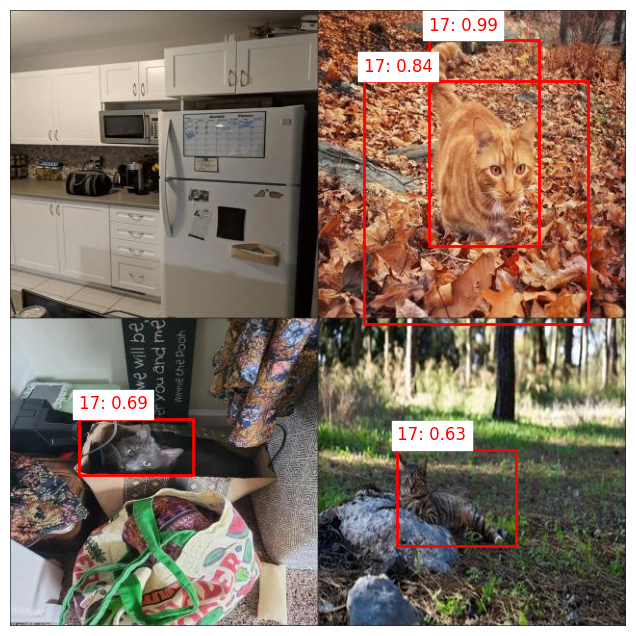

In [4]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

# tell the model to only make inferences
model.eval()

images = CustomImageDataset(images_path, labels_path)

# get an arbitrary sample
sample = images.get_image(sample_index)
img_tensor = sample.unsqueeze(0)
result = model(img_tensor)

# Plot the image
matplotlib_imshow(sample, result)